In [152]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as sps
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
sns.set_style("darkgrid")

In [153]:
file = pd.read_csv("data.csv")
columns = file.columns[8:15]
time_labels = [int(i.split("_")[1]) for i in columns]
time_labels_np = np.array(time_labels).reshape(-1, 1)
time_check = max(time_labels)
print(time_labels)
bottom_limit = .69
top_limit = .705
train, test = train_test_split(file, test_size=0.2, random_state=42)

[0, 995, 4844, 8757, 12635, 16102, 19470]


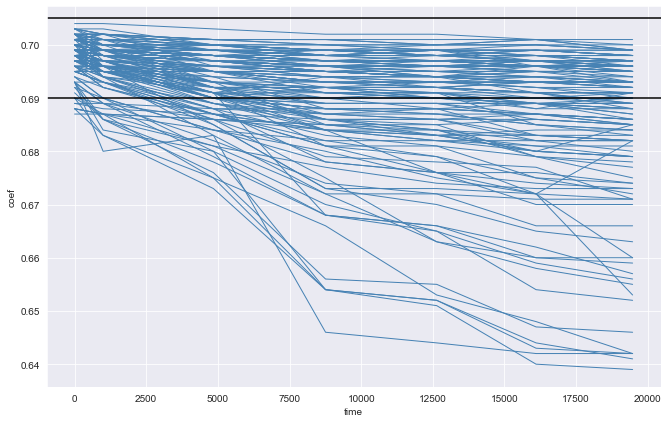

In [154]:
plt.figure(figsize=(11, 7))
for i in range(file.shape[0]):
    data = np.array(file[columns].iloc[i])
    plt.title('')
    plt.xlabel('time')
    plt.ylabel('coef')
    plt.plot(time_labels, data, color='steelblue', linewidth=1)
plt.axhline(y=bottom_limit, xmin=0, xmax=1, color='k', linewidth=1.5)
plt.axhline(y=top_limit, xmin=0, xmax=1, color='k', linewidth=1.5)

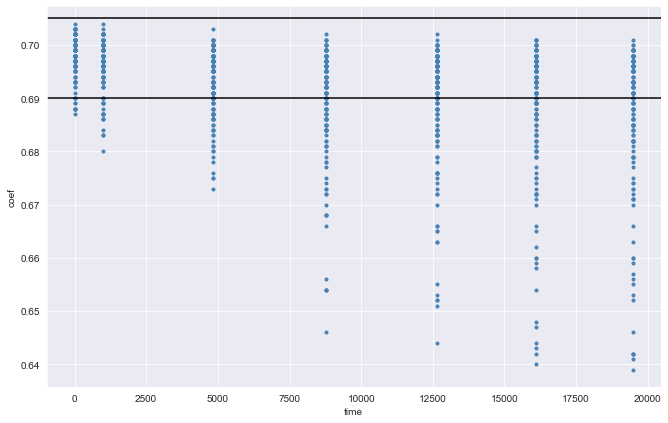

In [155]:
plt.figure(figsize=(11, 7))
for i in range(file.shape[0]):
    data = np.array(file[columns].iloc[i])
    plt.title('')
    plt.xlabel('time')
    plt.ylabel('coef')
    plt.scatter(time_labels, data, color='steelblue', marker=".")
plt.axhline(y=bottom_limit, xmin=0, xmax=1, color='k', linewidth=1.5)
plt.axhline(y=top_limit, xmin=0, xmax=1, color='k', linewidth=1.5)

In [156]:
weibull = sps.weibull_max

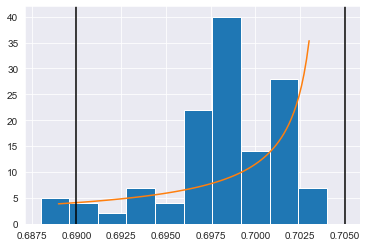

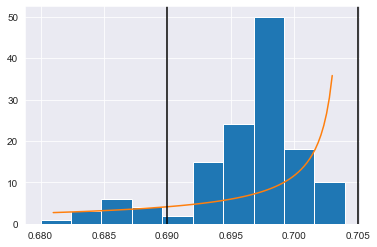

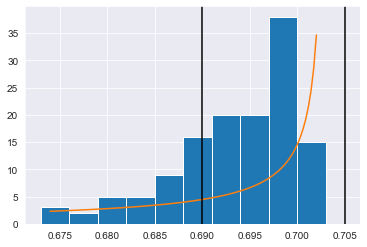

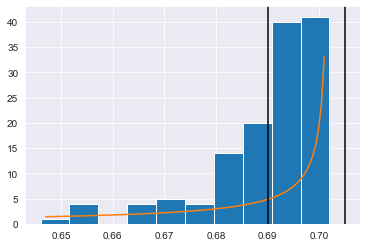

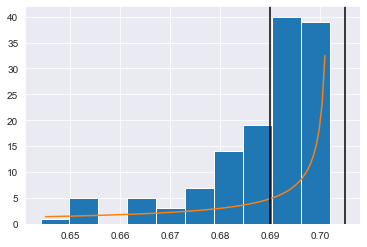

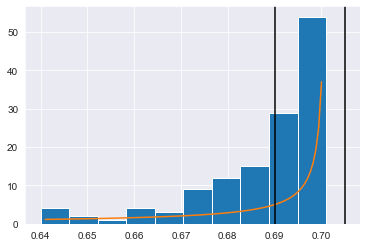

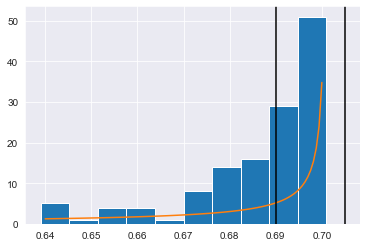

In [157]:
shape = []
loc = []
scale = []
for i in columns:
    _shape, _loc, _scale = weibull.fit(train[i])
    shape.append(_shape)
    loc.append(_loc)
    scale.append(_scale)
    x = np.linspace(train[i].min() + 0.001, train[i].max() - 0.001, 100)
    plt.hist(train[i])
    plt.plot(x, weibull(_shape, _loc, _scale).pdf(x))
    plt.axvline(bottom_limit, 0, 1, color='k')
    plt.axvline(top_limit, 0, 1, color='k')
    plt.show()

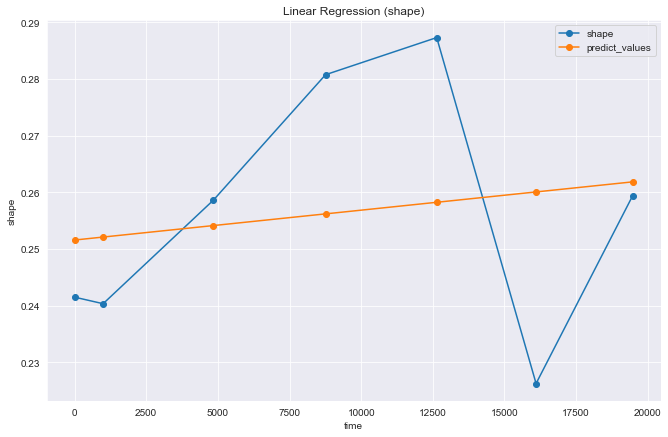

In [158]:
model_shape = LinearRegression()
model_shape.fit(time_labels_np, shape)
predict_values = model_shape.predict(time_labels_np)
plt.figure(figsize=(11, 7))
plt.title('Linear Regression (shape)')
plt.xlabel('time')
plt.ylabel('shape')
plt.plot(time_labels, shape, label="shape", marker="o")
plt.plot(time_labels, predict_values, label="predict_values", marker="o")
plt.legend()


[0.70391605 0.70375109 0.70311295 0.70246419 0.70182124 0.70124643
 0.70068804]


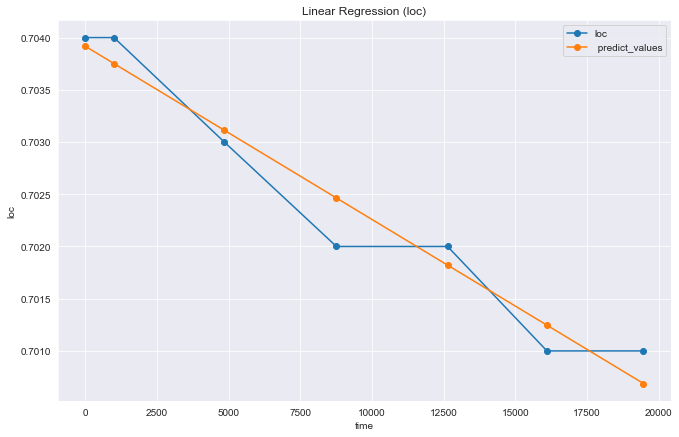

In [159]:
model_loc = LinearRegression()
model_loc.fit(time_labels_np, loc)
predict_values = model_loc.predict(time_labels_np)
plt.figure(figsize=(11, 7))
plt.title('Linear Regression (loc)')
plt.xlabel('time')
plt.ylabel('loc')
plt.plot(time_labels, loc, label="loc", marker="o")
plt.plot(time_labels, predict_values, label=" predict_values", marker="o")
plt.legend()
print(predict_values)

[1.33926921 1.3334547  1.31096217 1.28809565 1.26543365 1.24517343
 1.22549174]


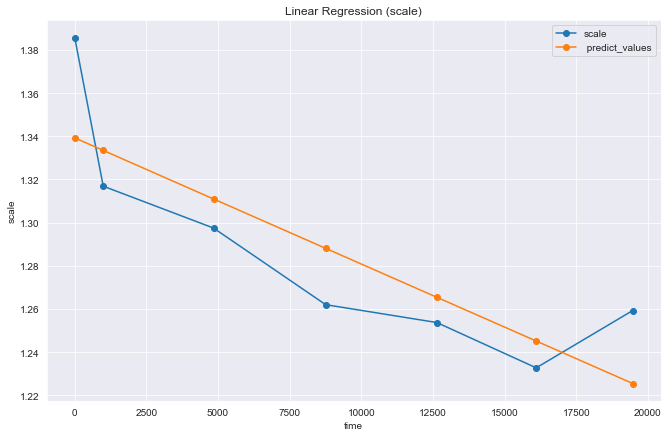

In [160]:
model_scale = LinearRegression()
model_scale.fit(time_labels_np, scale)
predict_values = model_scale.predict(time_labels_np)
plt.figure(figsize=(11, 7))
plt.title('Linear Regression (scale)')
plt.xlabel('time')
plt.ylabel('scale')
plt.plot(time_labels, scale, label="scale", marker="o")
plt.plot(time_labels, predict_values, label=" predict_values", marker="o")
plt.legend()
print(predict_values)

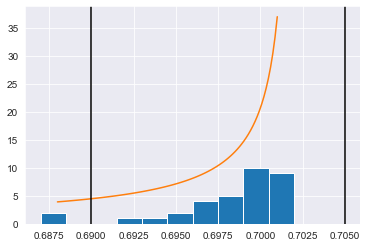

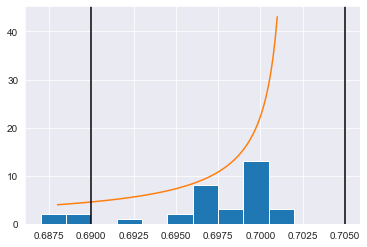

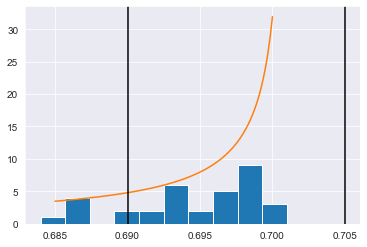

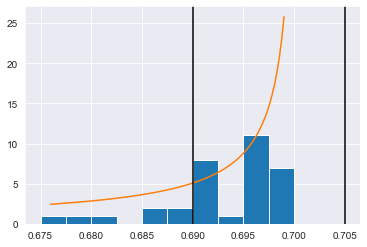

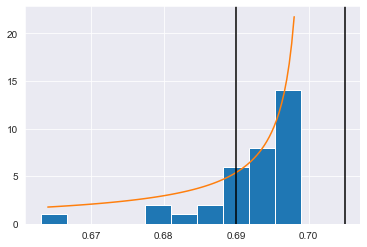

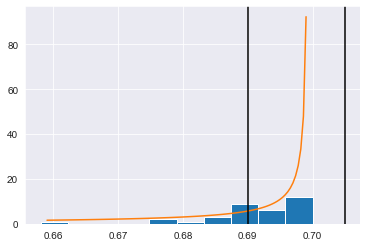

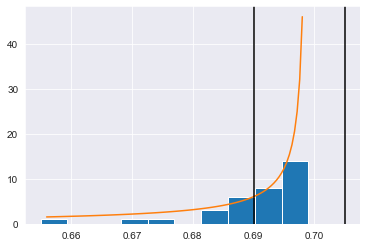

In [161]:
shape0_test, loc0_test, scale0_test = weibull.fit(test[columns[0]])
shape_test = []
loc_test = []
scale_test = []
for i, j in zip(time_labels, columns):
    _shape = shape0_test + model_shape.coef_[0] * i
    _loc = loc0_test + model_loc.coef_[0] * i
    _scale = scale0_test + model_scale.coef_[0] * i
    shape_test.append(_shape)
    loc_test.append(_loc)
    scale_test.append(_scale)
    plt.hist(test[j])
    x = np.linspace(test[j].min() + 0.001, test[j].max() - 0.001, 100)
    plt.plot(x, weibull(_shape, _loc, _scale).pdf(x))
    plt.axvline(bottom_limit, 0, 1, color='k')
    plt.axvline(top_limit, 0, 1, color='k')
    plt.show()

In [162]:
test_working_predict = []
for shape, loc, scale in zip(shape_test, loc_test, scale_test):
    test_working_predict.append(weibull.cdf(x=top_limit, c=shape, loc=loc, scale=scale) - weibull.cdf(x=bottom_limit, c=shape, loc=loc, scale=scale))
    print(weibull.cdf(x=top_limit, c=shape, loc=loc, scale=scale), weibull.cdf(x=bottom_limit, c=shape, loc=loc, scale=scale))

1.0 0.6911041955004132
1.0 0.6922507327316901
1.0 0.6967705267891544
1.0 0.7015158792229079
1.0 0.7063874571329389
1.0 0.7109032559568993
1.0 0.7154539639134653


In [163]:
test_working_experiment = []
for i in columns:
    working = 0
    for j in test[i]:
        if bottom_limit < j < top_limit:
            working += 1
    test_working_experiment.append(working / test.shape[0])
print(test_working_experiment)

[0.9411764705882353, 0.8823529411764706, 0.7941176470588235, 0.7647058823529411, 0.7058823529411765, 0.6470588235294118, 0.6470588235294118]


In [164]:
test_error = 0
for p, e in zip(test_working_predict, test_working_experiment):
    test_error += pow((p - e) / e, 2)
test_error = np.sqrt(test_error / len(test_working_predict))

In [165]:
print(f"Процент рабочих устройств\nВремя: Прогноз (Реальное значение)")
for t, p, e in zip(time_labels, test_working_predict, test_working_experiment):
    print(f"{t}: {p} ({e})")
print(f"Ошибка: {test_error}")

Процент рабочих устройств
Время: Прогноз (Реальное значение)
0: 0.30889580449958676 (0.9411764705882353)
995: 0.30774926726830987 (0.8823529411764706)
4844: 0.3032294732108456 (0.7941176470588235)
8757: 0.2984841207770921 (0.7647058823529411)
12635: 0.29361254286706107 (0.7058823529411765)
16102: 0.2890967440431007 (0.6470588235294118)
19470: 0.2845460360865347 (0.6470588235294118)
Ошибка: 0.608305856828462
